In [315]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import copy
import logging
import contextily as cx
import gtfs_kit as gk
import fastsim as fsim
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory, busnetwork
from openbustools.drivecycle.physics import conditions, energy, vehicle

In [306]:
epsg = 32148
timezone = "America/Los_Angeles"
coord_ref_center = [386910,69022]
chop_n = 500
point_sep_m = 200
dem_file = Path("..","data","kcm_spatial","usgs10m_dem_32148.tif")
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime","gnss_validated").glob("*") if x.is_dir()]
realtime_folder = Path("..","data","kcm_sensor_realtime")
gnss_solution_file = Path("..","data","gnss","CEErover_solution_20240312160029.LLH")

veh = fsim.vehicle.Vehicle.from_vehdb(63, veh_file=Path("..", "data", "FASTSim_py_veh_db.csv")) # New Flyer XE40

model_folder = "../logs_no_resample"
run_label = "/kcm"
model_type = "GRU"
fold_num = 0
version = "version_0"
model = model_utils.load_model(model_folder, run_label, model_type, fold_num, version=version)
model.eval()

GRU(
  (loss_fn): MSELoss()
  (min_em): MinuteEmbedding(
    (em): Embedding(1440, 48)
  )
  (day_em): DayEmbedding(
    (em): Embedding(7, 4)
  )
  (rnn): GRU(5, 32, num_layers=3, dropout=0.1)
  (feature_extract): Linear(in_features=84, out_features=1, bias=True)
  (feature_extract_activation): ReLU()
)

### Altoona, FastSIM Standardized Cycle Comparison (validate BEB model)

In [307]:
altoona_economy = {
    "manhattan.csv": (2767 / 1000),
    "orange_county.csv": (2176 / 1000),
    "hd_udds.csv": (1980 / 1000)
}
economies = []
for cycle_file in ["manhattan.csv", "orange_county.csv", "hd_udds.csv"]:
    df = pd.read_csv(Path("..","data",cycle_file))
    cycle = {
        "cycSecs": df["Time (seconds)"].to_numpy(),
        "cycMps": df["Speed (mph)"].to_numpy() * 0.44704,
        "cycGrade": np.zeros(df.shape[0]),
        "cycRoadType": np.zeros(df.shape[0])
    }
    cycle = fsim.cycle.Cycle.from_dict(cycle)
    sim_drive = fsim.simdrive.SimDrive(cycle, veh)
    sim_drive.sim_drive()
    economies.append(sim_drive.battery_kwh_per_mi)
for i,cycle_file in enumerate(["manhattan.csv", "orange_county.csv", "hd_udds.csv"]):
    print(f"{cycle_file}: (FASTSim BEB): {economies[i]:.2f} kWh/mi | (Altoona: {altoona_economy[cycle_file]:.2f} kWh/mi)")

2024-04-25 16:01:35.016 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00767 exceeds tolerance of 0.001
2024-04-25 16:01:35.390 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00386 exceeds tolerance of 0.001
2024-04-25 16:01:35.391 | simdrive.py:2290 | WARNING: trace miss speed 1.62466 m/s exceeds tolerance of 1.0 m/s


manhattan.csv: (FASTSim BEB): 2.75 kWh/mi | (Altoona: 2.77 kWh/mi)
orange_county.csv: (FASTSim BEB): 2.00 kWh/mi | (Altoona: 2.18 kWh/mi)
hd_udds.csv: (FASTSim BEB): 1.99 kWh/mi | (Altoona: 1.98 kWh/mi)


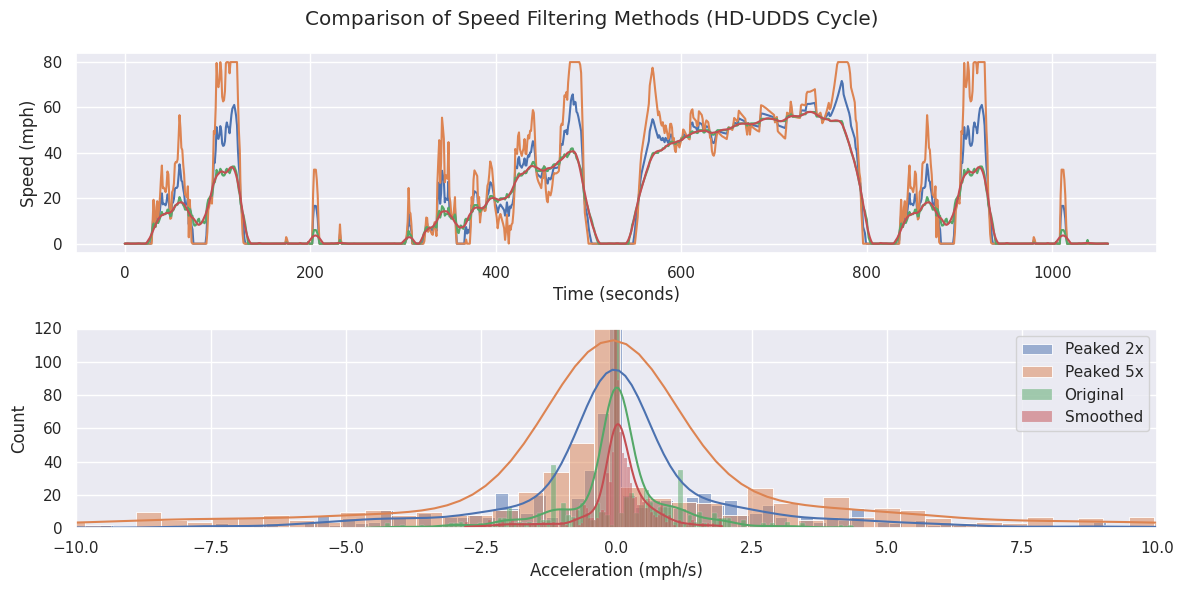

In [308]:
# Smooth or increase velocity peaks
df['Speed (mph)_smoothed'] = spatial.apply_sg_filter(df["Speed (mph)"].to_numpy(), clip_min=0, clip_max=80)
df['Speed (mph)_peaked_2'] = spatial.apply_peak_filter(df['Speed (mph)'].to_numpy(), scalar=2.0, window_len=51, clip_min=0, clip_max=80)
df['Speed (mph)_peaked_5'] = spatial.apply_peak_filter(df['Speed (mph)'].to_numpy(), scalar=5.0, window_len=51, clip_min=0, clip_max=80)

fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes = axes.flatten()

# Speed profiles
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_peaked_2"], ax=axes[0])
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_peaked_5"], ax=axes[0])
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)"], ax=axes[0])
sns.lineplot(x=df["Time (seconds)"], y=df["Speed (mph)_smoothed"], ax=axes[0])
axes[0].set_xlabel("Time (seconds)")
axes[0].set_ylabel("Speed (mph)")

# Acceleration histograms
df['acc_mph_s'] = df['Speed (mph)'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_smoothed'] = df['Speed (mph)_smoothed'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_peaked_2'] = df['Speed (mph)_peaked_2'].diff() / df['Time (seconds)'].diff()
df['acc_mph_s_peaked_5'] = df['Speed (mph)_peaked_5'].diff() / df['Time (seconds)'].diff()
sns.histplot(df['acc_mph_s_peaked_2'], bins=100, kde=True, ax=axes[1], label="Peaked 2x")
sns.histplot(df['acc_mph_s_peaked_5'], bins=100, kde=True, ax=axes[1], label="Peaked 5x")
sns.histplot(df['acc_mph_s'], bins=100, kde=True, ax=axes[1], label="Original")
sns.histplot(df['acc_mph_s_smoothed'], bins=100, kde=True, ax=axes[1], label="Smoothed")
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(0, 120)
axes[1].set_xlabel("Acceleration (mph/s)")
axes[1].legend()

fig.suptitle("Comparison of Speed Filtering Methods (HD-UDDS Cycle)")
fig.tight_layout()
plt.show()
fig.savefig(Path("..","plots","speed_filtering.png"))

### Phone, Receiver, Realtime Comparison (validate realtime trajectory)

In [309]:
# Load phone/realtime data as trajectories
phone_trajectories = [standardfeeds.get_phone_trajectory(x, timezone=timezone, epsg=epsg, coord_ref_center=coord_ref_center, dem_file=dem_file, chop_n=chop_n, resample=True) for x in phone_trajectory_folders]
phone_gnss_trajectories = [standardfeeds.get_gnss_trajectory(x, gnss_solution_file=gnss_solution_file, resample=True) for x in phone_trajectories]
phone_realtime_trajectories = [standardfeeds.get_realtime_trajectory(x, realtime_folder=realtime_folder,  resample=True) for x in phone_trajectories]
print(len(phone_trajectories[0].gdf))
print(len(phone_gnss_trajectories[0].gdf))
print(len(phone_realtime_trajectories[0].gdf))

2151
2151
2015


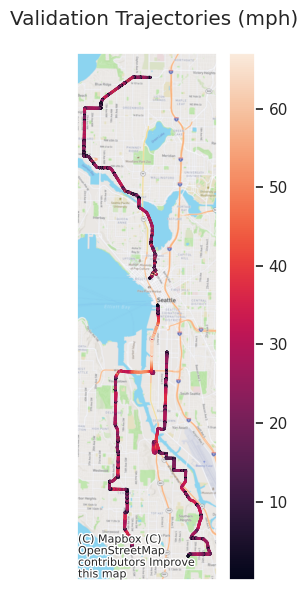

In [310]:
plot_df = []
for i, df in enumerate([phone_gnss_trajectories[0].gdf, phone_gnss_trajectories[1].gdf, phone_gnss_trajectories[2].gdf]):
    df['traj_num'] = i
    plot_df.append(df)
plot_df = pd.concat(plot_df)
plot_df['calc_speed_m_s'] = np.clip(plot_df['calc_speed_m_s'].to_numpy(), 0, 30) * 2.23694

fig, axes = plt.subplots(1,1,figsize=(3,6))
plot_df.plot(ax=axes, column="calc_speed_m_s", markersize=1, legend=True)
axes.set_xticks([])
axes.set_yticks([])
cx.add_basemap(ax=axes, crs=phone_gnss_trajectories[0].gdf.crs.to_string(), alpha=0.8, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
fig.suptitle("Validation Trajectories (mph)", horizontalalignment='center', verticalalignment='top')
fig.tight_layout()
fig.savefig(Path("..","plots","gnss_maps.png"))
plt.show()

2024-04-25 16:49:53.376 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.0198 exceeds tolerance of 0.001
2024-04-25 16:49:53.378 | simdrive.py:2290 | WARNING: trace miss speed 20.55221 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:53.798 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.01226 exceeds tolerance of 0.001
2024-04-25 16:49:53.800 | simdrive.py:2290 | WARNING: trace miss speed 10.41221 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:54.069 | simdrive.py:459 | WARNING: large time steps affect accuracy significantly; max time step = 70.0
2024-04-25 16:49:54.074 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.07459 exceeds tolerance of 0.001
2024-04-25 16:49:54.075 | simdrive.py:2290 | WARNING: trace miss speed 9.44103 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:54.488 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.02806 exceeds tolerance of 0.001
2024-04-25 16:49:54.490 | simdrive.py:2290 | WARNING: trace miss spee

Signal Error Phone/Realtime: 4.70 | Signal Error Phone/GNSS: 2.24
Avg. Phone: 2.13 kWh/mi
Avg. GNSS: 3.13 kWh/mi
Avg. Realtime: 1.90 kWh/mi



2024-04-25 16:49:56.788 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00228 exceeds tolerance of 0.001
2024-04-25 16:49:56.790 | simdrive.py:2290 | WARNING: trace miss speed 2.00775 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:57.160 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00272 exceeds tolerance of 0.001
2024-04-25 16:49:57.161 | simdrive.py:2290 | WARNING: trace miss speed 2.03282 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:57.531 | simdrive.py:459 | WARNING: large time steps affect accuracy significantly; max time step = 70.0
2024-04-25 16:49:57.535 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.06301 exceeds tolerance of 0.001
2024-04-25 16:49:57.536 | simdrive.py:2290 | WARNING: trace miss speed 2.22333 m/s exceeds tolerance of 1.0 m/s
2024-04-25 16:49:57.909 | simdrive.py:2272 | WARNING: trace miss distance fraction 0.00398 exceeds tolerance of 0.001
2024-04-25 16:49:57.911 | simdrive.py:2290 | WARNING: trace miss speed

Signal Error Phone/Realtime: 4.09 | Signal Error Phone/GNSS: 1.18
Avg. Phone: 1.66 kWh/mi
Avg. GNSS: 1.69 kWh/mi
Avg. Realtime: 1.63 kWh/mi



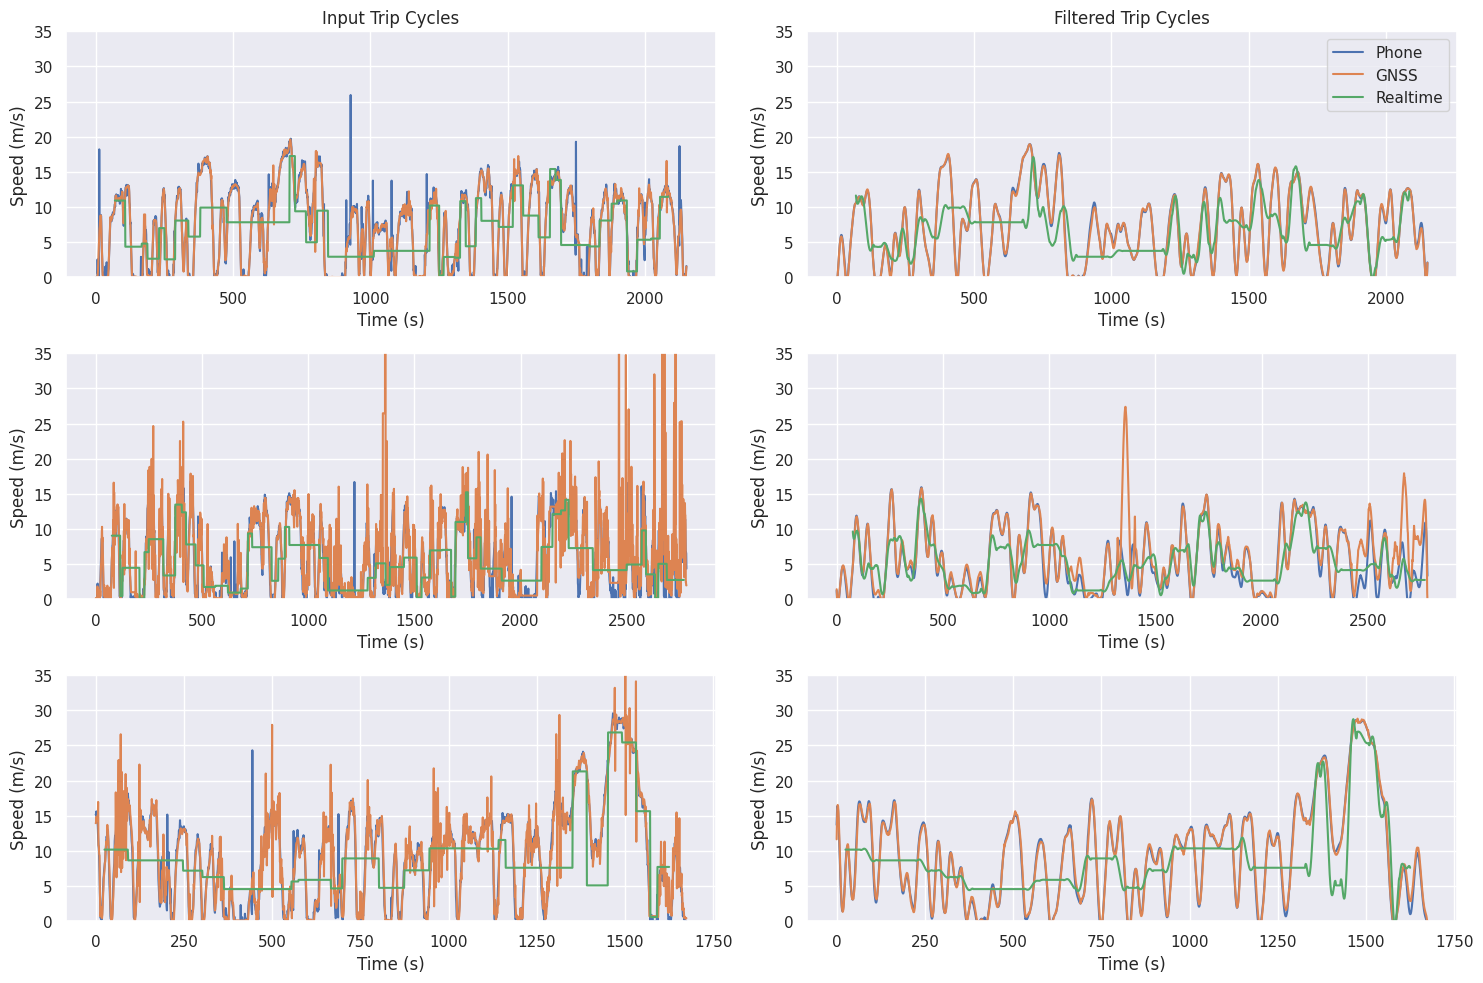

In [336]:
veh = fsim.vehicle.Vehicle.from_vehdb(63, veh_file=Path("..", "data", "FASTSim_py_veh_db.csv")) # New Flyer XE40

# Run fastsim energy analysis for each trajectory
economies_clipped = []
economies_clipped_smoothed = []
signal_errors_clipped = []
signal_errors_clipped_smoothed = []
# Phone/receiver/realtime energy consumption
for i, (traj_phone, traj_gnss, traj_realtime) in enumerate(zip(phone_trajectories, phone_gnss_trajectories, phone_realtime_trajectories)):
    # Energy analysis for phone
    cycle_phone = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_phone.gdf['calc_elev_m'], prepend=traj_phone.gdf['calc_elev_m'].iloc[0]), traj_phone.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": np.clip(traj_phone.gdf["calc_speed_m_s"].to_numpy(), 0, 30),
        "time_s": traj_phone.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_phone.gdf))
    }
    # cycle_phone = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_phone, new_dt=1))
    cycle_phone = fsim.cycle.Cycle.from_dict(cycle_phone)
    sim_drive_phone = fsim.simdrive.SimDrive(cycle_phone, veh)
    sim_drive_phone.sim_drive()
    # Energy analysis for GNSS
    cycle_gnss = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_gnss.gdf['calc_elev_m'], prepend=traj_gnss.gdf['calc_elev_m'].iloc[0]), traj_gnss.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": np.clip(traj_gnss.gdf["calc_speed_m_s"].to_numpy(), 0, 30),
        "time_s": traj_gnss.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_gnss.gdf))
    }
    cycle_gnss = fsim.cycle.Cycle.from_dict(cycle_gnss)
    sim_drive_gnss = fsim.simdrive.SimDrive(cycle_gnss, veh)
    sim_drive_gnss.sim_drive()
    # Energy analysis for realtime
    cycle_realtime = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_realtime.gdf['calc_elev_m'], prepend=traj_realtime.gdf['calc_elev_m'].iloc[0]), traj_realtime.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": np.clip(traj_realtime.gdf["calc_speed_m_s"].to_numpy(), 0, 30),
        "time_s": traj_realtime.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_realtime.gdf))
    }
    cycle_realtime = fsim.cycle.Cycle.from_dict(cycle_realtime)
    sim_drive_realtime = fsim.simdrive.SimDrive(cycle_realtime, veh)
    sim_drive_realtime.sim_drive()
    economies_clipped.append((sim_drive_phone.electric_kwh_per_mi, sim_drive_gnss.electric_kwh_per_mi, sim_drive_realtime.electric_kwh_per_mi))
    signal_errors_clipped.append((spatial.eval_signal_error(sim_drive_phone.cyc.mps, sim_drive_phone.cyc.time_s, sim_drive_realtime.cyc.mps, sim_drive_realtime.cyc.time_s), spatial.eval_signal_error(sim_drive_phone.cyc.mps, sim_drive_phone.cyc.time_s, sim_drive_gnss.cyc.mps, sim_drive_gnss.cyc.time_s)))
print(f"Signal Error Phone/Realtime: {np.mean([x[0] for x in signal_errors_clipped]):.2f} | Signal Error Phone/GNSS: {np.mean([x[1] for x in signal_errors_clipped]):.2f}")
print(f"Avg. Phone: {np.mean([x[0] for x in economies_clipped]):.2f} kWh/mi")
print(f"Avg. GNSS: {np.mean([x[1] for x in economies_clipped]):.2f} kWh/mi")
print(f"Avg. Realtime: {np.mean([x[2] for x in economies_clipped]):.2f} kWh/mi\n")

energy_results = []
economies_clipped = []
economies_clipped_smoothed = []
signal_errors_clipped = []
signal_errors_clipped_smoothed = []
# Phone/receiver/realtime energy consumption
for i, (traj_phone, traj_gnss, traj_realtime) in enumerate(zip(phone_trajectories, phone_gnss_trajectories, phone_realtime_trajectories)):
    # Energy analysis for phone
    cycle_phone = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_phone.gdf['calc_elev_m'], prepend=traj_phone.gdf['calc_elev_m'].iloc[0]), traj_phone.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_phone.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_phone.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_phone.gdf))
    }
    # cycle_phone = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_phone, new_dt=1))
    cycle_phone = fsim.cycle.Cycle.from_dict(cycle_phone)
    sim_drive_phone = fsim.simdrive.SimDrive(cycle_phone, veh)
    sim_drive_phone.sim_drive()
    # Energy analysis for GNSS
    cycle_gnss = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_gnss.gdf['calc_elev_m'], prepend=traj_gnss.gdf['calc_elev_m'].iloc[0]), traj_gnss.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_gnss.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_gnss.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_gnss.gdf))
    }
    cycle_gnss = fsim.cycle.Cycle.from_dict(cycle_gnss)
    sim_drive_gnss = fsim.simdrive.SimDrive(cycle_gnss, veh)
    sim_drive_gnss.sim_drive()
    # Energy analysis for realtime
    cycle_realtime = {
        "cycGrade": np.clip(spatial.divide_fwd_back_fill(np.diff(traj_realtime.gdf['calc_elev_m'], prepend=traj_realtime.gdf['calc_elev_m'].iloc[0]), traj_realtime.gdf['calc_dist_m']), -0.15, 0.15),
        "mps": spatial.apply_sg_filter(traj_realtime.gdf["calc_speed_m_s"].to_numpy(), clip_min=0, clip_max=30),
        "time_s": traj_realtime.gdf['cumul_time_s'].to_numpy(),
        "road_type": np.zeros(len(traj_realtime.gdf))
    }
    cycle_realtime = fsim.cycle.Cycle.from_dict(cycle_realtime)
    sim_drive_realtime = fsim.simdrive.SimDrive(cycle_realtime, veh)
    sim_drive_realtime.sim_drive()
    energy_results.append({"phone": (cycle_phone, sim_drive_phone), "gnss": (cycle_gnss, sim_drive_gnss), "realtime": (cycle_realtime, sim_drive_realtime)})
    economies_clipped_smoothed.append((sim_drive_phone.electric_kwh_per_mi, sim_drive_gnss.electric_kwh_per_mi, sim_drive_realtime.electric_kwh_per_mi))
    signal_errors_clipped_smoothed.append((spatial.eval_signal_error(sim_drive_phone.cyc.mps, sim_drive_phone.cyc.time_s, sim_drive_realtime.cyc.mps, sim_drive_realtime.cyc.time_s), spatial.eval_signal_error(sim_drive_phone.cyc.mps, sim_drive_phone.cyc.time_s, sim_drive_gnss.cyc.mps, sim_drive_gnss.cyc.time_s)))
print(f"Signal Error Phone/Realtime: {np.mean([x[0] for x in signal_errors_clipped_smoothed]):.2f} | Signal Error Phone/GNSS: {np.mean([x[1] for x in signal_errors_clipped_smoothed]):.2f}")
print(f"Avg. Phone: {np.mean([x[0] for x in economies_clipped_smoothed]):.2f} kWh/mi")
print(f"Avg. GNSS: {np.mean([x[1] for x in economies_clipped_smoothed]):.2f} kWh/mi")
print(f"Avg. Realtime: {np.mean([x[2] for x in economies_clipped_smoothed]):.2f} kWh/mi\n")

fig, axes = plt.subplots(3,2,figsize=(15,10))
for traj_n in range(3):
    ax = axes[traj_n,0]
    ax.legend().remove()
    ax.set_ylabel("Speed (m/s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylim(0,35)
    # Completely unprocessed trajectories
    sns.lineplot(x=phone_trajectories[traj_n].gdf["cumul_time_s"], y=phone_trajectories[traj_n].gdf["calc_speed_m_s"], ax=ax, label="Phone")
    sns.lineplot(x=phone_gnss_trajectories[traj_n].gdf["cumul_time_s"], y=phone_gnss_trajectories[traj_n].gdf["calc_speed_m_s"], ax=ax, label="GNSS")
    sns.lineplot(x=phone_realtime_trajectories[traj_n].gdf["cumul_time_s"], y=phone_realtime_trajectories[traj_n].gdf["calc_speed_m_s"], ax=ax, label="Realtime")
for traj_n in range(3):
    ax = axes[traj_n,1]
    ax.set_ylabel("Speed (m/s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylim(0,35)
    sim_drive_phone, sim_drive_gnss, sim_drive_realtime = energy_results[traj_n]["phone"][1], energy_results[traj_n]["gnss"][1], energy_results[traj_n]["realtime"][1]
    # Trajectories post-processed, post-fastsim
    sns.lineplot(x=sim_drive_phone.cyc.time_s, y=sim_drive_phone.cyc.mps, ax=ax, label="Phone")
    sns.lineplot(x=sim_drive_gnss.cyc.time_s, y=sim_drive_gnss.cyc.mps, ax=ax, label="GNSS")
    sns.lineplot(x=sim_drive_realtime.cyc.time_s, y=sim_drive_realtime.cyc.mps, ax=ax, label="Realtime")
axes[0,0].set_title("Input Trip Cycles")
axes[0,1].set_title("Filtered Trip Cycles")

[ax.legend().remove() for ax in axes.flatten()]
axes[0,1].legend()
fig.tight_layout()
plt.show()
fig.savefig(Path("..","plots","gnss_cycles.png"))

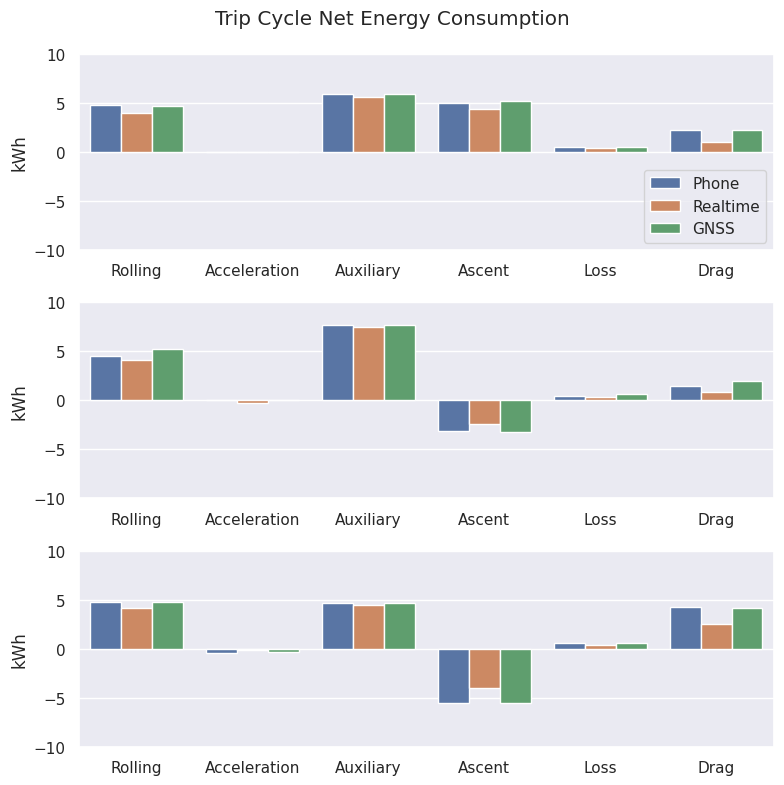

In [283]:
all_res = []
for i in range(len(energy_results)):
    for j, source in enumerate(['phone','realtime','gnss']):
        rr = energy_results[i][source][1].rr_kw.sum() / 3600
        accel = energy_results[i][source][1].accel_kw.sum() / 3600
        aux = energy_results[i][source][1].aux_in_kw.sum() / 3600
        ascent = energy_results[i][source][1].ascent_kw.sum() / 3600
        loss = energy_results[i][source][1].ess_loss_kw.sum() / 3600
        drag = energy_results[i][source][1].drag_kw.sum() / 3600
        total = sum([rr, accel, aux, ascent, loss, drag])
        res = {
            "Trajectory": i,
            "Source": source.capitalize() if source!='gnss' else source.upper(),
            "Total": total,
            "Rolling": rr,
            "Acceleration": accel,
            "Auxiliary": aux,
            "Ascent": ascent,
            "Loss": loss,
            "Drag": drag
        }
        all_res.append(res)
all_res = pd.DataFrame(all_res)
all_res = all_res.melt(id_vars=['Trajectory','Source'], value_vars=['Rolling','Acceleration','Auxiliary','Ascent','Loss','Drag'], var_name='component', value_name='kWh')
all_res

fig, axes = plt.subplots(3, 1, figsize=(8,8))
axes = axes.flatten()
for i in range(len(energy_results)):
    sns.barplot(all_res[all_res['Trajectory']==i], x="component", y="kWh", hue="Source", ax=axes[i])
    axes[i].legend().remove()
    axes[i].set_ylim(-10,10)
    axes[i].set_xlabel(None)
axes[0].legend(loc="lower right")
fig.suptitle("Trip Cycle Net Energy Consumption")
fig.tight_layout()
fig.savefig(Path("..","plots","gnss_net_energy.png"))

<Axes: xlabel='time', ylabel='calc_elev_m'>

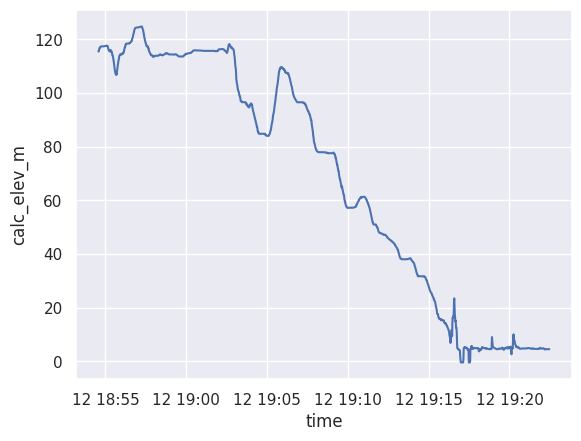

In [303]:
sns.lineplot(phone_trajectories[2].gdf['calc_elev_m'])

In [231]:
for i in range(len(energy_results)):
    print(f"Total Energy: Phone: {energy_results[i]['phone'][1].ess_kw_out_ach.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].ess_kw_out_ach.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].ess_kw_out_ach.sum() / 3600}")
    total_phone = sum([energy_results[i]['phone'][1].rr_kw.sum(), energy_results[i]['phone'][1].accel_kw.sum(), energy_results[i]['phone'][1].aux_in_kw.sum(), np.clip(energy_results[i]['phone'][1].ascent_kw.sum(), min), energy_results[i]['phone'][1].ess_loss_kw.sum(), energy_results[i]['phone'][1].drag_kw.sum()])
    total_realtime = sum([energy_results[i]['realtime'][1].rr_kw.sum(), energy_results[i]['realtime'][1].accel_kw.sum(), energy_results[i]['realtime'][1].aux_in_kw.sum(), energy_results[i]['realtime'][1].ascent_kw.sum(), energy_results[i]['realtime'][1].ess_loss_kw.sum(), energy_results[i]['realtime'][1].drag_kw.sum()])
    total_gnss = sum([energy_results[i]['gnss'][1].rr_kw.sum(), energy_results[i]['gnss'][1].accel_kw.sum(), energy_results[i]['gnss'][1].aux_in_kw.sum(), energy_results[i]['gnss'][1].ascent_kw.sum(), energy_results[i]['gnss'][1].ess_loss_kw.sum(), energy_results[i]['gnss'][1].drag_kw.sum()])
    print(f"Summed Energy: Phone: {total_phone / 3600} Realtime: {total_realtime / 3600} GNSS: {total_gnss / 3600}")
    print(f"Total RR: Phone: {energy_results[i]['phone'][1].rr_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].rr_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].rr_kw.sum() / 3600}")
    print(f"Total Acc: Phone: {energy_results[i]['phone'][1].accel_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].accel_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].accel_kw.sum() / 3600}")
    print(f"Total Aux: Phone: {energy_results[i]['phone'][1].aux_in_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].aux_in_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].aux_in_kw.sum() / 3600}")
    print(f"Total Ascent: Phone: {energy_results[i]['phone'][1].ascent_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].ascent_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].ascent_kw.sum() / 3600}")
    print(f"Total Loss: Phone: {energy_results[i]['phone'][1].ess_loss_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].ess_loss_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].ess_loss_kw.sum() / 3600}")
    print(f"Total Drag: Phone: {energy_results[i]['phone'][1].drag_kw.sum() / 3600} Realtime: {energy_results[i]['realtime'][1].drag_kw.sum() / 3600} GNSS: {energy_results[i]['gnss'][1].drag_kw.sum() / 3600}")
    print()

Total Energy: Phone: 21.12885972517236 Realtime: 17.25099929740508 GNSS: 21.19713330559795
Summed Energy: Phone: 18.484720390307373 Realtime: 15.451911726012922 GNSS: 18.595996629892387
Total RR: Phone: 4.769198331908563 Realtime: 3.9733786532617716 GNSS: 4.734902727381114
Total Acc: Phone: 0.011628675467335843 Realtime: 0.03596297516660823 GNSS: 0.010916283017811154
Total Aux: Phone: 5.972222222222222 Realtime: 5.594444444444444 GNSS: 5.972222222222222
Total Ascent: Phone: 4.983455820441989 Realtime: 4.4088839510357225 GNSS: 5.166714034198593
Total Loss: Phone: 0.516184538085709 Realtime: 0.3716067874064974 GNSS: 0.5087936503565098
Total Drag: Phone: 2.232030802181557 Realtime: 1.0676349146978756 GNSS: 2.2024477127161335

Total Energy: Phone: 14.038852697804174 Realtime: 12.688869841307257 GNSS: 16.775430748622675
Summed Energy: Phone: 11.119606306475651 Realtime: 10.289274422308159 GNSS: 12.35696691346732
Total RR: Phone: 4.535258304429531 Realtime: 4.170477707421877 GNSS: 5.24370893

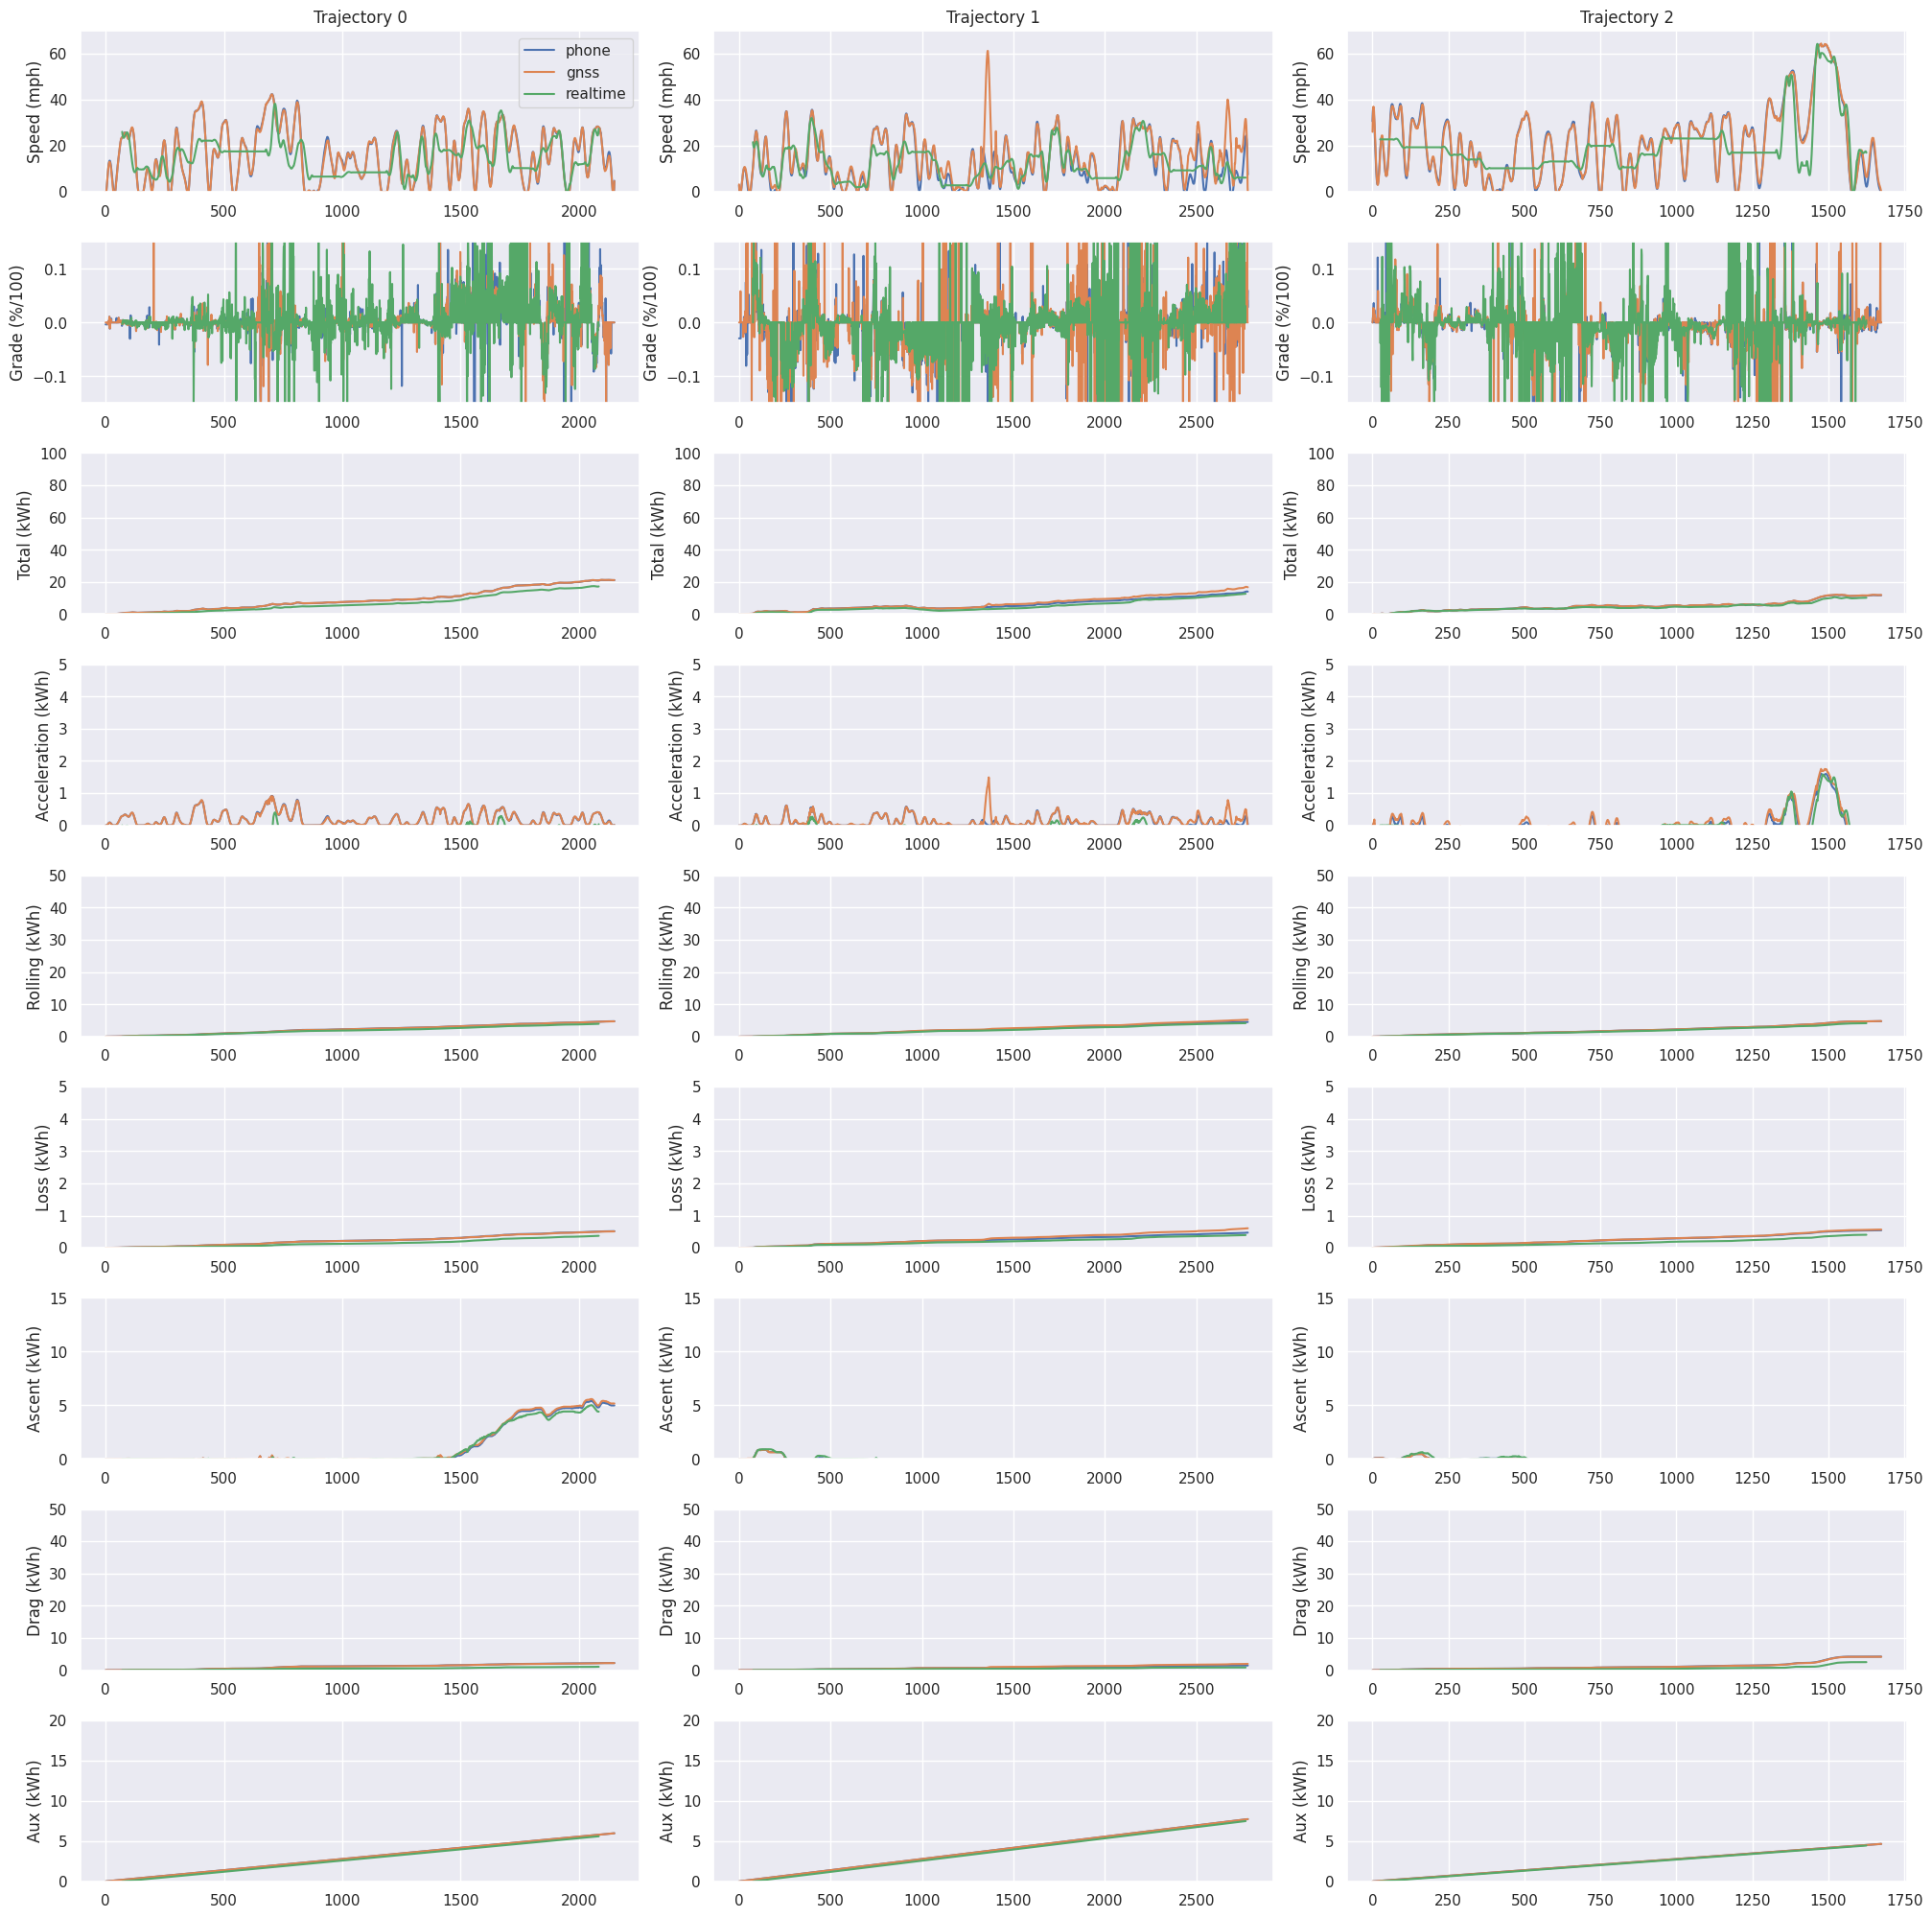

In [177]:
plotting.drive_cycle_energy_plot(energy_results)

### Aggregated and Predicted Cycle Comparison

In [317]:
# Load a static feed and break each shape into regularly spaced points
static_file = Path("..", "data", "kcm_static", "2024_03_08")
static_feed = gk.read_feed(static_file, dist_units="km")
route_shape_points = standardfeeds.segmentize_shapes(static_feed, epsg=epsg, point_sep_m=point_sep_m)
route_shape_points

{'10002005':                         geometry  shape_id  seq_id  dist_shape_m
 0   POINT (391110.775 69083.359)  10002005       0           0.0
 1   POINT (391040.237 69254.319)  10002005       1         200.0
 2   POINT (390952.886 69434.162)  10002005       2         400.0
 3   POINT (390909.299 69624.094)  10002005       3         600.0
 4   POINT (390829.443 69780.216)  10002005       4         800.0
 5   POINT (390629.678 69783.017)  10002005       5        1000.0
 6   POINT (390562.708 69615.659)  10002005       6        1200.0
 7   POINT (390554.832 69415.827)  10002005       7        1400.0
 8   POINT (390546.657 69216.001)  10002005       8        1600.0
 9   POINT (390383.547 69184.052)  10002005       9        1800.0
 10  POINT (390183.770 69191.516)  10002005      10        2000.0
 11  POINT (389983.848 69194.628)  10002005      11        2200.0
 12  POINT (389783.871 69196.887)  10002005      12        2400.0
 13  POINT (389583.957 69202.182)  10002005      13        2600.

In [318]:
# Load set of realtime data to aggregate to route shapes; join it to static feed ids
realtime_files = [Path("..", "data", "kcm_realtime", "processed", "analysis", f"2024_03_1{x}.pkl") for x in np.arange(5)]
realtime_data = [pd.read_pickle(i) for i in realtime_files]
realtime_data = pd.concat(realtime_data)
realtime_data = pd.merge(realtime_data[['calc_speed_m_s', 'x', 'y', 'trip_id']], static_feed.trips[['trip_id', 'shape_id']], on='trip_id')
realtime_data = gpd.GeoDataFrame(realtime_data, geometry=gpd.points_from_xy(realtime_data.x, realtime_data.y), crs=epsg)

# Group realtime data by shape and find closest static point in that shape for each observation
route_shape_metrics = realtime_data.groupby('shape_id').apply(lambda x: gpd.sjoin_nearest(x, route_shape_points[x.name]), include_groups=False)
route_shape_metrics = route_shape_metrics.drop(columns=['shape_id']).reset_index()
route_shape_metrics = route_shape_metrics.groupby(['shape_id', 'seq_id'], as_index=False).agg({
    'calc_speed_m_s': ['mean', 'std'],
    'trip_id': 'count',
    'geometry': 'first'
})
route_shape_metrics = {
    'geometry': route_shape_metrics[('geometry', 'first')],
    'speed_mean': route_shape_metrics[('calc_speed_m_s', 'mean')],
    'speed_std': route_shape_metrics[('calc_speed_m_s', 'std')],
    'count_n': route_shape_metrics[('trip_id', 'count')],
    'shape_id': route_shape_metrics['shape_id'],
    'seq_id': route_shape_metrics['seq_id']
}
route_shape_metrics = gpd.GeoDataFrame(route_shape_metrics, crs=epsg)
route_shape_metrics.head()

geometry  speed_mean  speed_std  count_n  shape_id  \
0  POINT (391108.519 69084.656)    0.113126   0.187324        4  10002005   
1  POINT (391033.379 69268.051)    7.291531   3.182043       15  10002005   
2  POINT (390943.954 69454.261)    9.788471   1.441442       11  10002005   
3  POINT (390909.393 69629.258)    9.133222   3.018736       39  10002005   
4  POINT (390828.489 69780.101)    7.045980   2.725258       65  10002005   

   seq_id  
0       0  
1       1  
2       2  
3       3  
4       4

In [319]:
# Subset of shape_ids for testing
good_routes = ['20033002', '11345009', '20345010', '10027004']
bad_routes = ['10057005', '30165010', '30271024', '10102003']
plot_routes = good_routes
plot_df = route_shape_metrics[route_shape_metrics['shape_id'].isin(plot_routes)].copy()
plot_df_groups = {k: v for k, v in plot_df.groupby('shape_id')}

In [320]:
# Turning regularly spaced points w/speeds into calculated distances and times
# Important to base distance on sequence id because some points do not have observations
for k,df in plot_df_groups.items():
    plot_df_groups[k]['cumul_dist_m'] = df['seq_id'] * point_sep_m
    plot_df_groups[k]['calc_dist_m'] = df['cumul_dist_m'].diff().fillna(0)
    plot_df_groups[k]['calc_time_s'] = df['calc_dist_m'] / df['speed_mean']
    plot_df_groups[k]['cumul_time_s'] = df['calc_time_s'].cumsum()
    plot_df_groups[k]['speed_std'] = df['speed_std'].bfill().ffill()

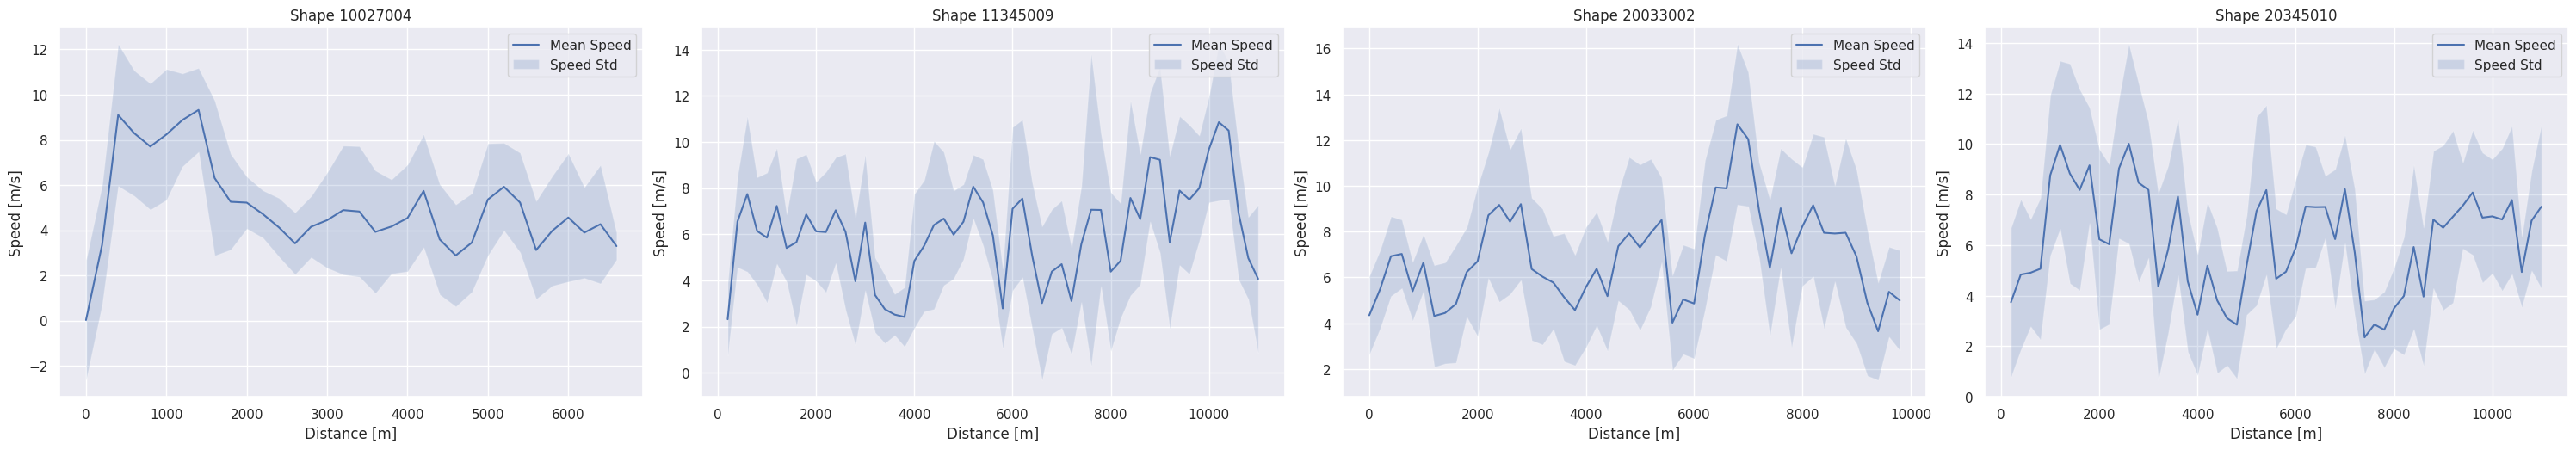

In [321]:
# Overview of the routes
fig, axes = plt.subplots(1,len(plot_df_groups), figsize=(30,5))
fig.tight_layout()
for i, (k,df) in enumerate(plot_df_groups.items()):
    ax = axes[i]
    ax.plot(df['cumul_dist_m'], df['speed_mean'], label="Mean Speed")
    ax.fill_between(df['cumul_dist_m'], df['speed_mean'] - df['speed_std'], df['speed_mean'] + df['speed_std'], alpha=0.2, label="Speed Std")
    ax.set_xlabel("Distance [m]")
    ax.set_ylabel("Speed [m/s]")
    ax.set_title(f"Shape {k}")
    ax.legend()

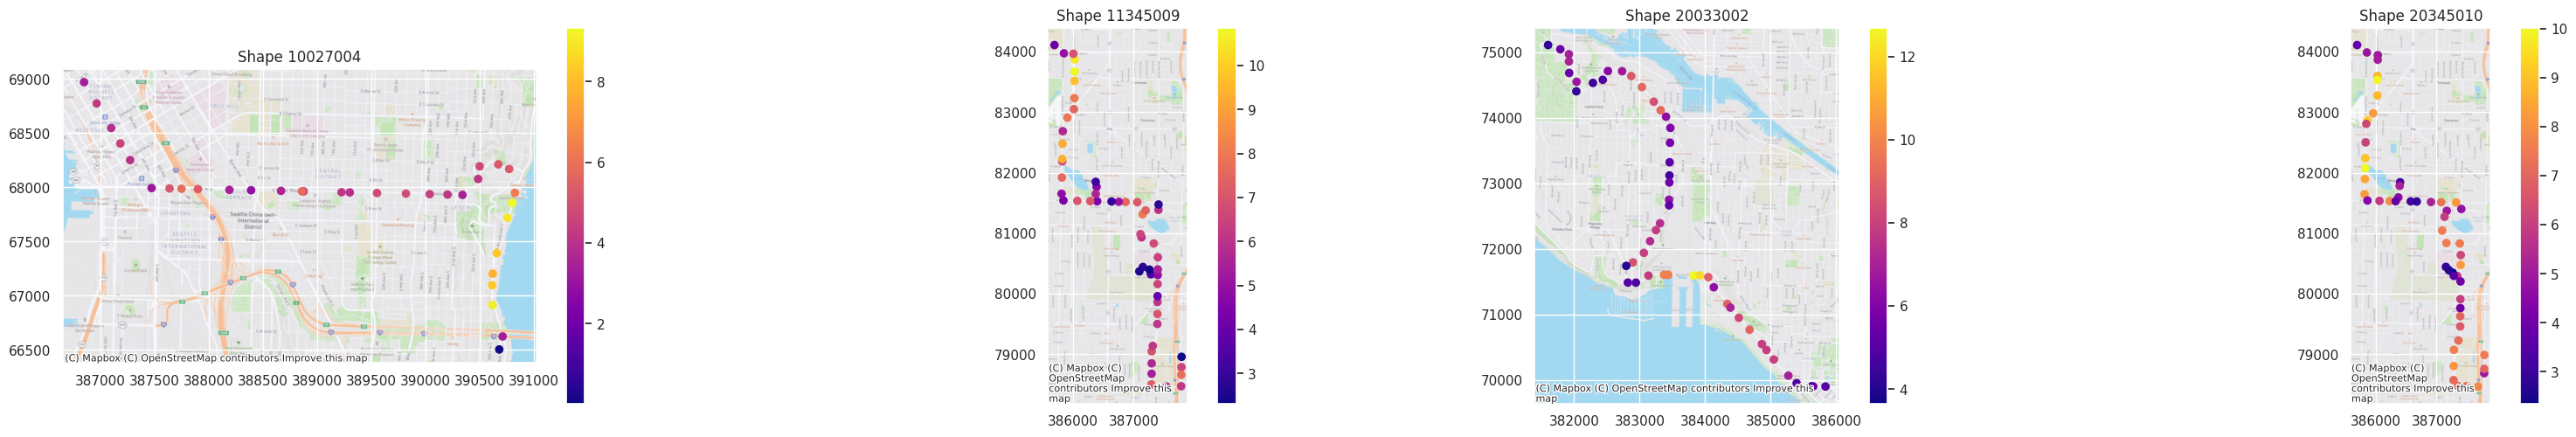

In [322]:
# Map of the routes
fig, axes = plt.subplots(1,len(plot_df_groups), figsize=(30,5))
fig.tight_layout()
for i, (k,df) in enumerate(plot_df_groups.items()):
    ax = axes[i]
    df.plot(ax=ax, column='speed_mean', cmap='plasma', legend=True)
    cx.add_basemap(ax=ax, crs=plot_df.crs.to_string(), alpha=0.6, source=cx.providers.MapBox(accessToken=os.getenv(key="MAPBOX_TOKEN")))
    ax.set_title(f"Shape {k}")

In [323]:
# Create trajectory for each shape
plot_trajectories = []
for shape_id, df in plot_df_groups.items():
    traj = trajectory.Trajectory(
        point_attr={
            "lon": df.to_crs(4326).geometry.x.to_numpy(),
            "lat": df.to_crs(4326).geometry.y.to_numpy(),
            "locationtime": df.cumul_time_s.to_numpy(),
            "measured_speed_m_s": df.speed_mean.to_numpy(),
            "seq_id": df.seq_id.to_numpy(),
            "count_n": df.count_n.to_numpy()
        },
        traj_attr={
            'shape_id': shape_id,
            "coord_ref_center": coord_ref_center,
            "epsg": epsg,
            "dem_file": dem_file,
            "t_min_of_day": 9*60,
            "t_day_of_week": 4,
            "start_epoch": df.cumul_time_s.iloc[0],
            "end_epoch": df.cumul_time_s.iloc[-1]
        },
        resample=False
    )
    plot_trajectories.append(traj)

In [324]:
# Predict speeds along each trajectory
busnetwork.update_travel_times(plot_trajectories, model)

INFO: GPU available: True (cuda), used: True
2024-04-25 16:13:37.960 | setup.py:156 | INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-04-25 16:13:37.990 | setup.py:159 | INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-04-25 16:13:37.991 | setup.py:169 | INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-04-25 16:13:37.992 | setup.py:179 | INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-04-25 16:13:38.473 | cuda.py:61 | INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<Axes: >

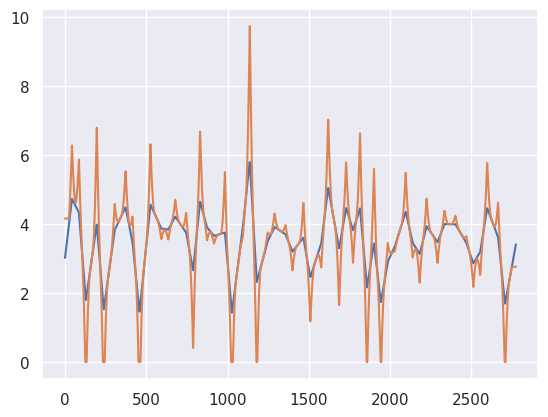

In [385]:
# Try peak then sg or sg then peak
sns.lineplot(resampled_pred)
sns.lineplot(spatial.apply_peak_filter(resampled_pred, window_len=51, scalar=5.0, clip_min=0, clip_max=30))

2024-04-25 17:43:57.353 | legend.py:1363 | WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-25 17:43:57.371 | legend.py:1363 | WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2024-04-25 17:43:57.387 | legend.py:1363 | WARNING: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


economies:
Avg. Agg: 1.60 kWh/mi
Avg. Pred: 2.19 kWh/mi

RMSE Agg/Pred: 0.59 kWh/mi


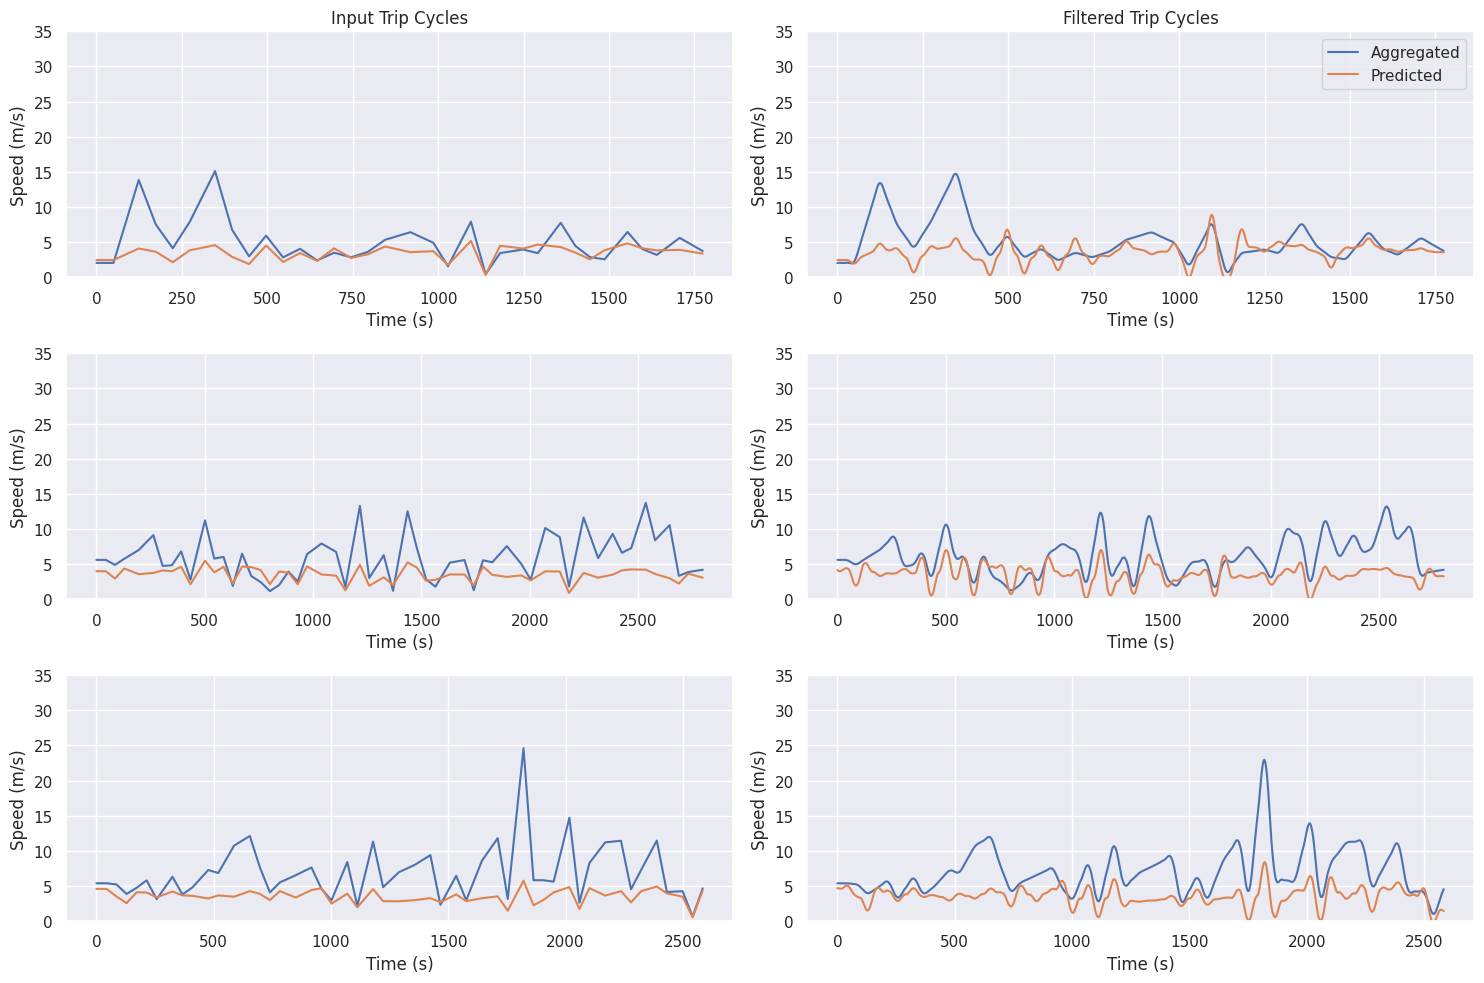

In [386]:
energy_results = []
economies = []

for i, traj in enumerate(plot_trajectories):
    # Prior to filtering; resample both aggregated and predicted cycles
    resampled_time = np.arange(traj.gdf['cumul_time_s'].min(), traj.gdf['cumul_time_s'].max(), 1)
    resampled_agg = np.interp(resampled_time, traj.gdf['cumul_time_s'].to_numpy(), traj.gdf['calc_speed_m_s'].to_numpy())
    resampled_pred = np.interp(resampled_time, traj.gdf['cumul_time_s'].to_numpy(), traj.gdf['pred_speed_m_s'].to_numpy())
    grade = spatial.divide_fwd_back_fill(np.diff(traj.gdf['calc_elev_m'], prepend=traj.gdf['calc_elev_m'].iloc[0]), traj.gdf['calc_dist_m'])
    resampled_grade = np.interp(resampled_time, traj.gdf['cumul_time_s'].to_numpy(), grade)
    # Energy analysis for aggregated
    cycle_agg = {
        "cycGrade": np.clip(resampled_grade, -0.15, 0.15),
        "mps": spatial.apply_sg_filter(resampled_agg, clip_min=0, clip_max=30),
        "time_s": resampled_time,
        "road_type": np.zeros(len(traj.gdf))
    }
    cycle_agg = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_agg, new_dt=1))
    sim_drive_agg = fsim.simdrive.SimDrive(cycle_agg, veh)
    sim_drive_agg.sim_drive()
    # Energy analysis for predicted
    cycle_pred = {
        "cycGrade": np.clip(resampled_grade, -0.15, 0.15),
        "mps": spatial.apply_sg_filter(spatial.apply_peak_filter(resampled_pred, window_len=51, scalar=5.0, clip_min=0, clip_max=30), clip_min=0, clip_max=30),
        "time_s": resampled_time,
        "road_type": np.zeros(len(traj.gdf))
    }
    cycle_pred = fsim.cycle.Cycle.from_dict(fsim.cycle.resample(cycle_pred, new_dt=1))
    sim_drive_pred = fsim.simdrive.SimDrive(cycle_pred, veh)
    sim_drive_pred.sim_drive()
    energy_results.append({"agg": (cycle_agg, sim_drive_agg), "pred": (cycle_pred, sim_drive_pred)})
    economies.append((sim_drive_agg.electric_kwh_per_mi, sim_drive_pred.electric_kwh_per_mi))
print(f"economies:")
print(f"Avg. Agg: {np.mean([x[0] for x in economies]):.2f} kWh/mi")
print(f"Avg. Pred: {np.mean([x[1] for x in economies]):.2f} kWh/mi\n")
print(f"RMSE Agg/Pred: {np.sqrt(np.mean([(x-y)**2 for x,y in economies])):.2f} kWh/mi")


fig, axes = plt.subplots(3,2,figsize=(15,10))
for traj_n in range(3):
    ax = axes[traj_n,0]
    ax.legend().remove()
    ax.set_ylabel("Speed (m/s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylim(0,35)
    # Completely unprocessed trajectories
    sns.lineplot(x=plot_trajectories[traj_n].gdf["cumul_time_s"], y=plot_trajectories[traj_n].gdf["calc_speed_m_s"], ax=ax, label="Aggregated")
    sns.lineplot(x=plot_trajectories[traj_n].gdf["cumul_time_s"], y=plot_trajectories[traj_n].gdf["pred_speed_m_s"], ax=ax, label="Predicted")
for traj_n in range(3):
    ax = axes[traj_n,1]
    ax.set_ylabel("Speed (m/s)")
    ax.set_xlabel("Time (s)")
    ax.set_ylim(0,35)
    sim_drive_agg, sim_drive_pred = energy_results[traj_n]["agg"][1], energy_results[traj_n]["pred"][1]
    # Trajectories post-processed, post-fastsim
    sns.lineplot(x=sim_drive_agg.cyc.time_s, y=sim_drive_agg.cyc.mps, ax=ax, label="Aggregated")
    sns.lineplot(x=sim_drive_pred.cyc.time_s, y=sim_drive_pred.cyc.mps, ax=ax, label="Predicted")
axes[0,0].set_title("Input Trip Cycles")
axes[0,1].set_title("Filtered Trip Cycles")

[ax.legend().remove() for ax in axes.flatten()]
axes[0,1].legend()
fig.tight_layout()
plt.show()
fig.savefig(Path("..","plots","agg_pred_cycles.png"))

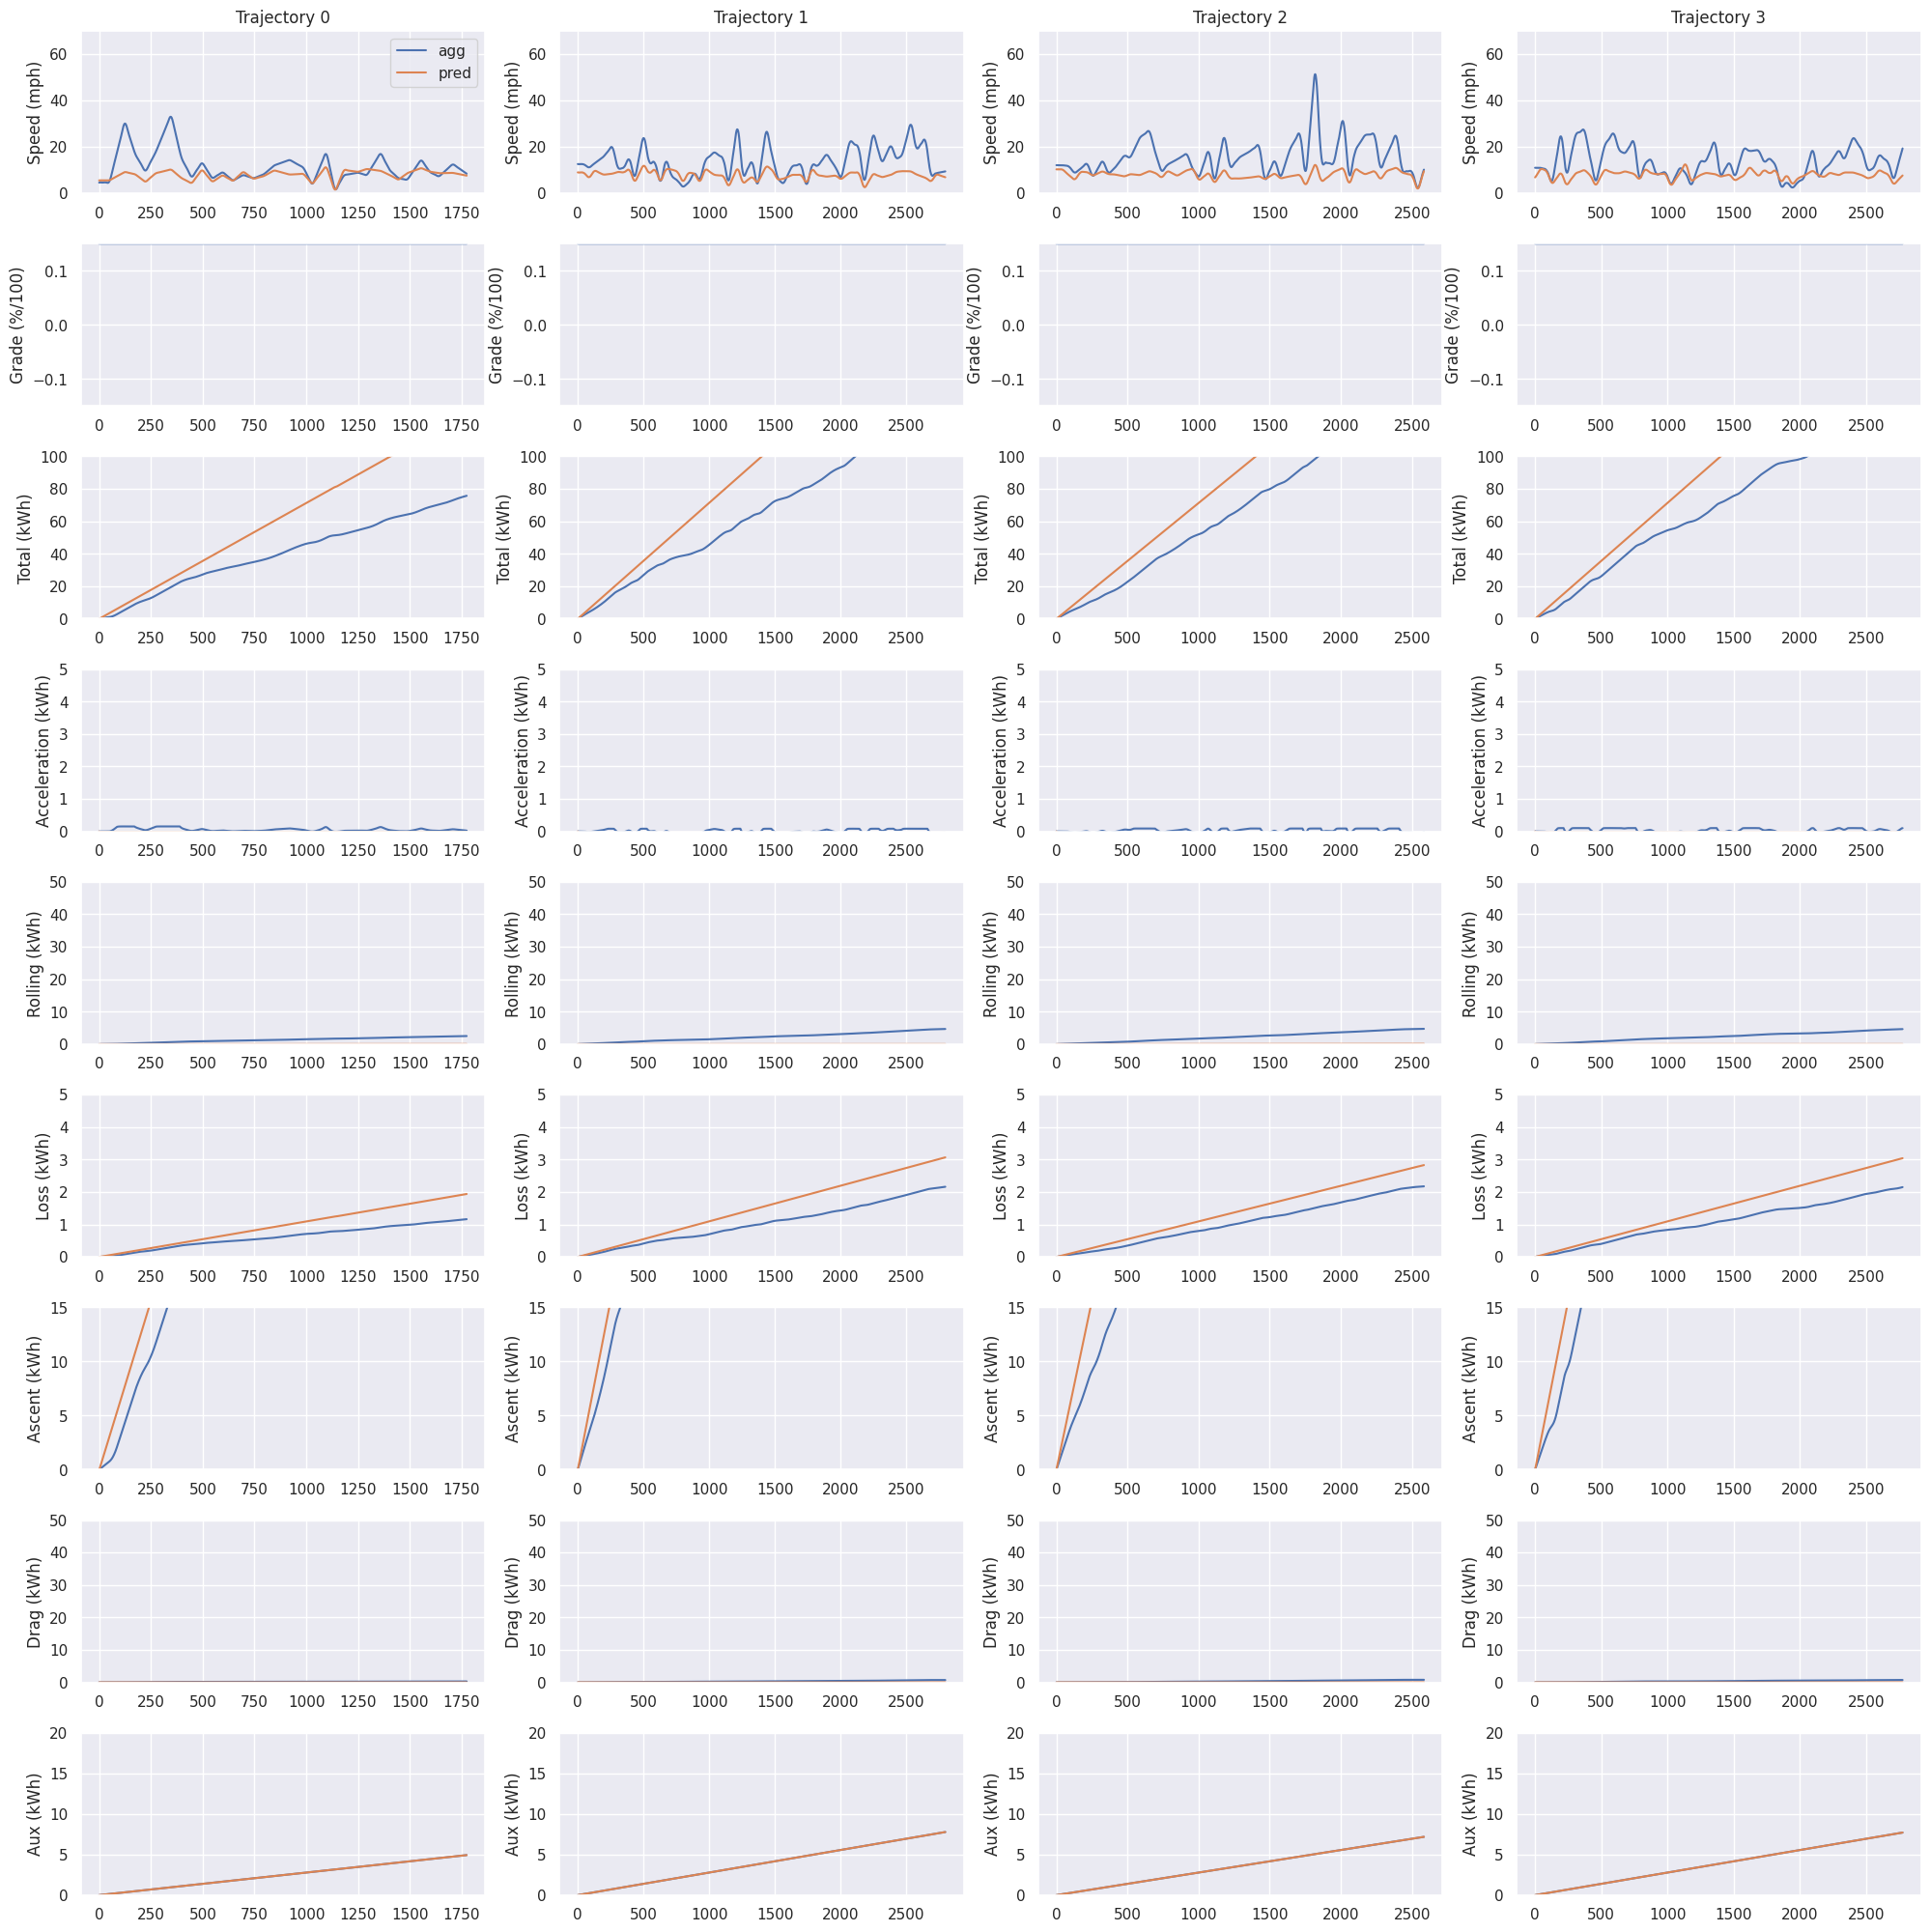

In [374]:
plotting.drive_cycle_energy_plot(energy_results)

### Compare Cycle Filtering, Boosting Accuracy of Predicted GTFS-RT

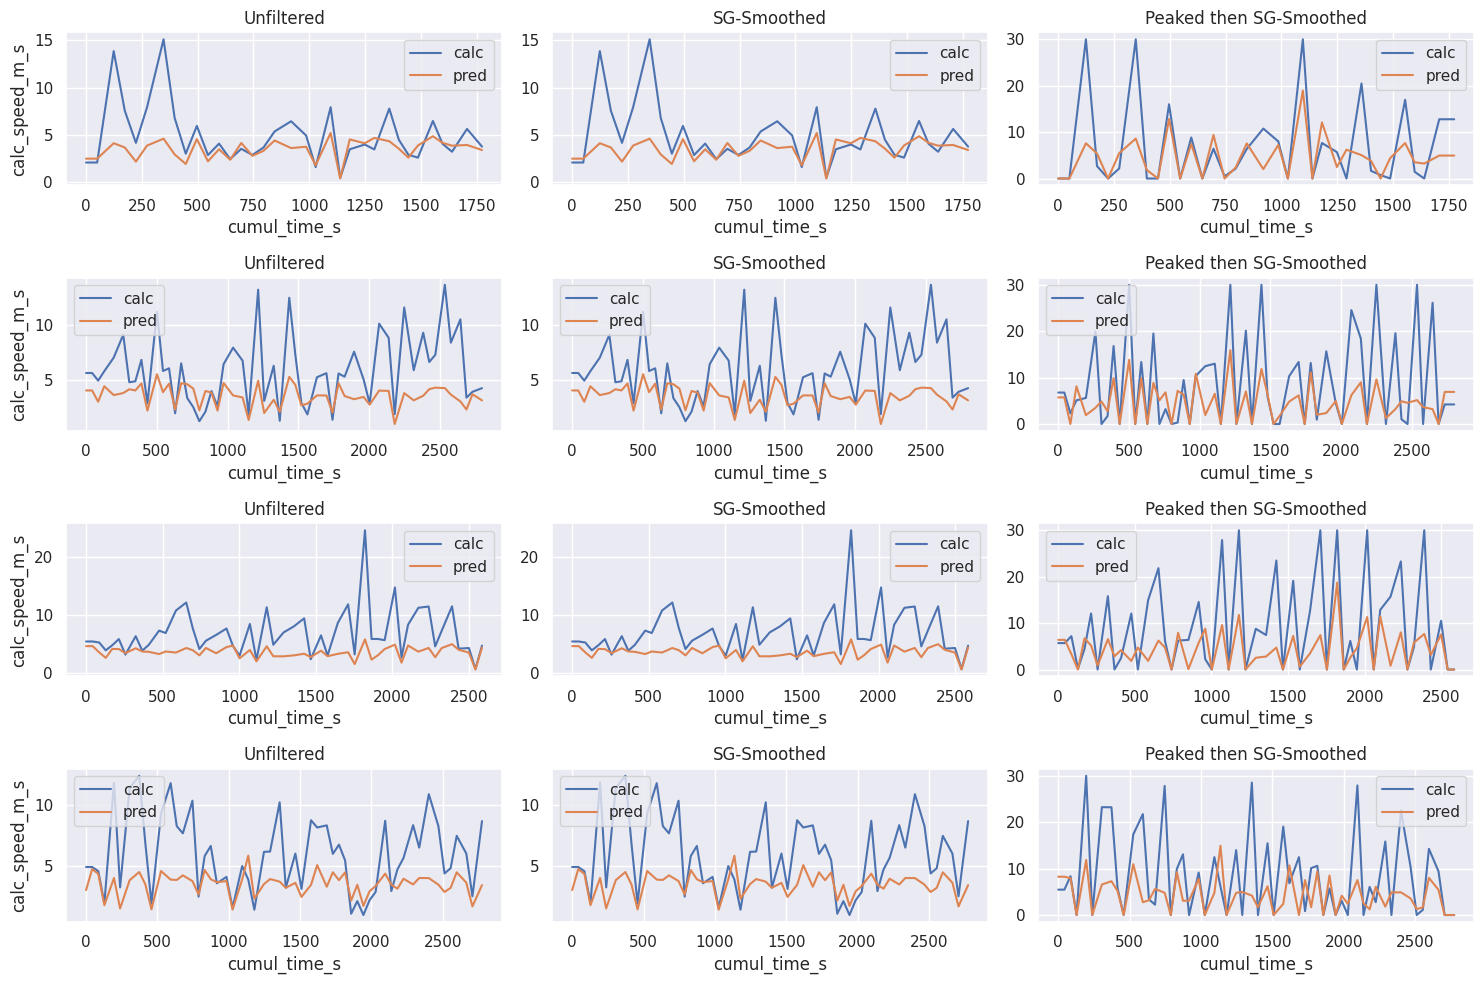

In [327]:
# Compare the smoothing / peaking of the aggregated data to the model predictions
fig, axes = plt.subplots(len(plot_trajectories), 3, figsize=(15,10))
for i in range(len(plot_trajectories)):
    # Unfiltered
    sns.lineplot(data=plot_trajectories[i].gdf, x='cumul_time_s', y='calc_speed_m_s', label='calc', ax=axes[i,0])
    sns.lineplot(data=plot_trajectories[i].gdf, x='cumul_time_s', y='pred_speed_m_s', label='pred', ax=axes[i,0])
    axes[i,0].set_title("Unfiltered")
    # Smoothed
    calc_smoothed = spatial.apply_sg_filter(plot_trajectories[i].gdf['calc_speed_m_s'].to_numpy(), window_len_factor=.1, clip_min=0, clip_max=30)
    pred_smoothed = spatial.apply_sg_filter(plot_trajectories[i].gdf['pred_speed_m_s'].to_numpy(), window_len_factor=.1, clip_min=0, clip_max=30)
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=calc_smoothed, label='calc', ax=axes[i,1])
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=pred_smoothed, label='pred', ax=axes[i,1])
    axes[i,1].set_title("SG-Smoothed")
    # Peaked then smoothed
    calc_peak_smoothed = spatial.apply_sg_filter(spatial.apply_peak_filter(plot_trajectories[i].gdf['calc_speed_m_s'].to_numpy(), scalar=5.0, clip_min=0, clip_max=30), window_len_factor=.1, clip_min=0, clip_max=30)
    pred_peak_smoothed = spatial.apply_sg_filter(spatial.apply_peak_filter(plot_trajectories[i].gdf['pred_speed_m_s'].to_numpy(), scalar=5.0, clip_min=0, clip_max=30), window_len_factor=.1, clip_min=0, clip_max=30)
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=calc_peak_smoothed, label='calc', ax=axes[i,2])
    sns.lineplot(x=plot_trajectories[i].gdf['cumul_time_s'], y=pred_peak_smoothed, label='pred', ax=axes[i,2])
    axes[i,2].set_title("Peaked then SG-Smoothed")
axes[0,0].legend()
axes[0,1].legend()
fig.tight_layout()